# Inverse design optimization of a waveguide taper

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

In this notebook, we will show how to use the adjoint plugin to compute the gradient with respect to the boundaries of a structure defined using a `JaxPolySlab`.

We will apply this capability to design a non-adiabatic waveguide taper between a narrow and wide waveguide, based loosely on `Michaels, Andrew, and Eli Yablonovitch. "Leveraging continuous material averaging for inverse electromagnetic design." Optics express 26.24 (2018): 31717-31737`.

We start by importing our typical python packages, `jax`, `tidy3d` and its `adjoint` plugin.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import jax
import jax.numpy as jnp

import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run

## Set up

Next we will define some basic parameters of the waveguide, such as the input and output waveguide dimensions, taper width, and taper length.

In [2]:
wavelength = 1.0
freq0 = td.C_0 / wavelength

wg_width_in = 0.5 * wavelength
wg_width_out = 5.0 * wavelength

wg_medium = td.material_library["Si3N4"]["Philipp1973Sellmeier"]
wg_jax_medium = td.material_library["Si3N4"]["Philipp1973Sellmeier"]

wg_length = 1 * wavelength
taper_length = 10.

spc_pml = 1.5 * wavelength

Lx = wg_length + taper_length + wg_length
Ly = spc_pml + max(wg_width_in, wg_width_out) + spc_pml

Our taper is defined as a set of `num_points` connected vertices in a polygon. We define the fixed x positions of each vertex and then construct the y positions for the starting device (linear taper).

In [3]:
num_points = 101
x_start = -taper_length / 2
x_end = +taper_length / 2
xs = np.linspace(x_start, x_end, num_points)

ys0 = (wg_width_in + (wg_width_out - wg_width_in) * (xs - x_start) / (x_end - x_start)) / 2.0


Let's plot these points to make sure they seem reasonable.

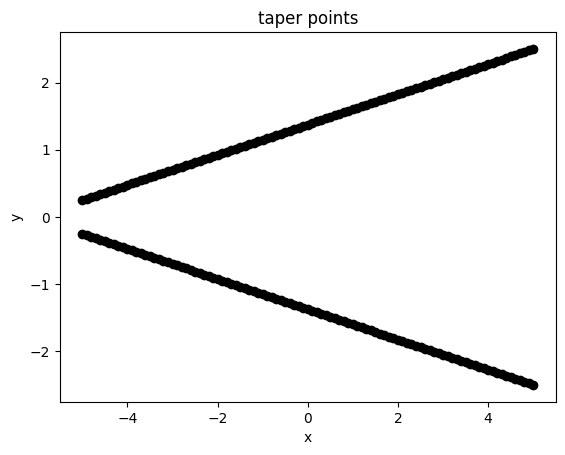

In [4]:
plt.plot(xs, +ys0, 'ko-')
plt.plot(xs, -ys0, 'ko-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('taper points')
plt.show()

Let's wrap this in a function that constructs these points and then creates a `JaxPolySlab` for use in the `JaxSimulation`.

In [5]:
def make_taper(ys) -> tda.JaxPolySlab:
    """Create a JaxPolySlab for the taper based on the supplied y values."""
    
    # note, jax doesnt work well with concatenating, so we just construct these vertices for Tidy3D in a loop.
    
    vertices = []
    for x, y in zip(xs, ys):
        vertices.append((x, y))
    for x, y in zip(xs[::-1], ys[::-1]):
        vertices.append((x, -y))
        
    return tda.JaxPolySlab(
        vertices=vertices,
        slab_bounds=(-1, 1),
        axis=2
    )

Now we'll call this function and plot the geometry for a sanity check.

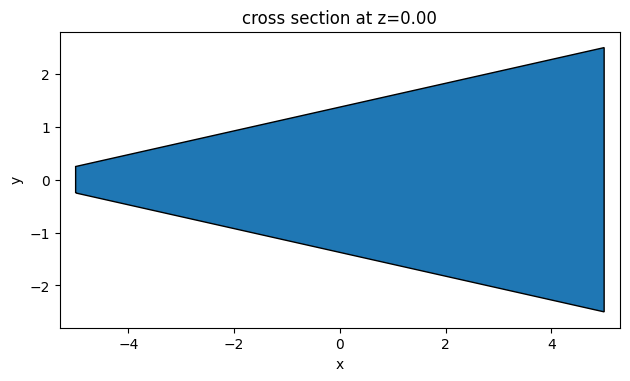

In [6]:
# sanity check to see the polyslab
taper_geo = make_taper(ys0)
ax = taper_geo.plot(z=0)

Next, let's write a function that generates a `JaxSimulation` given a set of y coordinates for the taper, including the monitors, sources, and waveguide geometries. The `JaxStructureStaticMedium` object allows to combine any Tidy3D medium and a `jax`-compatible geometry. This way, we can use dispersive material models from the Tidy3D material library or experimental data.

In [7]:
def make_sim(ys, include_field_mnt: bool = False) -> tda.JaxSimulation:
    """Make a JaxSimulation for the taper."""

    wg_in_box = td.Box.from_bounds(
        rmin=(-Lx, -wg_width_in/2, -td.inf),
        rmax=(-Lx/2 + wg_length + 0.01, +wg_width_in/2, +td.inf)
    )

    wg_out_box = td.Box.from_bounds(
        rmin=(+Lx/2 - wg_length - 0.01, -wg_width_out/2, -td.inf),
        rmax=(+Lx, +wg_width_out/2, +td.inf)
    )
    
    taper_geo = make_taper(ys)
    
    wg_in = td.Structure(geometry=wg_in_box, medium=wg_medium)
    wg_out = td.Structure(geometry=wg_out_box, medium=wg_medium)
    taper = tda.JaxStructureStaticMedium(
        geometry=taper_geo, medium=wg_jax_medium
    )
    
    mode_source=td.ModeSource(
        center=(-Lx/2 + wg_length/2, 0, 0),
        size=(0, td.inf, td.inf),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
        direction="+",
    )
    
    mode_monitor=td.ModeMonitor(
        center=(+Lx/2 - wg_length/2, 0, 0),
        size=(0, td.inf, td.inf),
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name='mode',
    )
    
    field_monitor=td.FieldMonitor(
        center=(0, 0, 0),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        name='field',
    )


    return tda.JaxSimulation(
        size=(Lx, Ly, 0),
        structures=[wg_in, wg_out],
        input_structures=[taper],
        output_monitors=[mode_monitor],
        monitors=[field_monitor] if include_field_mnt else [],
        sources=[mode_source],
        run_time=100/freq0,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
    )
    

17:53:03 -03 WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

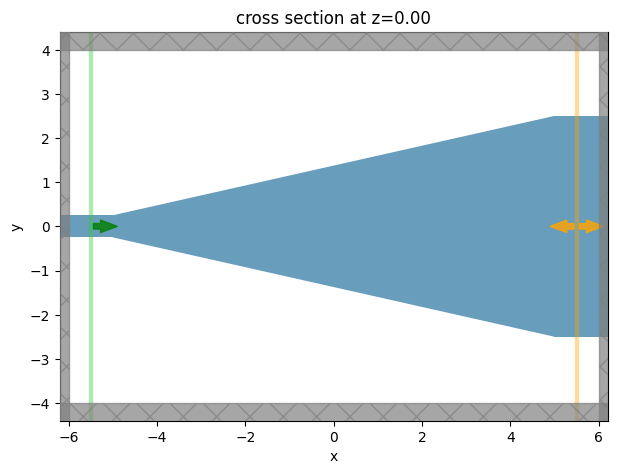

In [8]:
sim = make_sim(ys0)
ax = sim.plot(z=0)

> Note: we get a warning because the polyslab edges in x intersect with the waveguides. We can ignore this warning because we don't actually care about the gradient w.r.t these edges.

## Defining Objective

Now that we have a function to create our `JaxSimulation`, we need to define our objective function.

We will try to optimize the power transmission into the fundamental mode on the output waveguide, so we write a function to postprocess a `JaxSimulationData` to give this result.

In [9]:
def measure_transmission(sim_data: tda.JaxSimulationData) -> float:
    """Measure the first order transmission."""
    amp_data = sim_data['mode'].amps
    amp = amp_data.sel(f=freq0, direction="+", mode_index=0)
    return abs(amp) ** 2

Next, we will define a few convenience functions to generate our taper `y` values passed on our objective function parameters.

We define a set of parameters that can range from -infinity to +infinity, but project onto the range [`wg_width_out` and `wg_width_in`] through a `tanh()` function.

We do this to constrain the taper values within this range in a smooth and differentiable way.

We also write an inverse function to get the parameters given a set of desired `y` values and assert that this function works properly.

In [10]:
def get_ys(parameters: np.ndarray) -> np.ndarray:
    """Convert arbitrary parameters to y values for the vertices (parameter (-inf, inf) -> wg width of (wg_width_out, wg_width_in)."""
    
    params_between_0_1 = (jnp.tanh(np.pi * parameters) + 1.0) / 2.0
    
    params_scaled = params_between_0_1 * (wg_width_out - wg_width_in) / 2.0
    ys = params_scaled + wg_width_in / 2
    return ys

def get_params(ys: np.ndarray) -> np.ndarray:
    """inverse of above, get parameters from ys"""
    params_scaled = ys - wg_width_in / 2
    params_between_0_1 = 2 * params_scaled / (wg_width_out - wg_width_in)
    tanh_pi_params = 2 * params_between_0_1 - 1
    params = np.arctanh(tanh_pi_params) / np.pi
    return params

# assert that the inverse function works properly
params_test = 2 * (np.random.random((10,)) - 0.5)
ys_test = get_ys(params_test)
assert np.allclose(get_params(ys_test), params_test)
                   
    

We then make a function that simply wraps our previously defined functions to generate a `JaxSimulation` given some parameters.

In [11]:
def make_sim_params(parameters: np.ndarray, include_field_mnt: bool=False) -> tda.JaxSimulation:
    """Make the simulation out of raw parameters."""
    ys = get_ys(parameters)
    return make_sim(ys, include_field_mnt=include_field_mnt)

### Smoothness Penalty

It is important to ensure that the final device does not contain feature sizes below a minimum radius of curvature, otherwise there could be considerable difficulty in fabricating the device reliably.

For this, we implement a penalty function that approximates the radius of curvature about each vertex and introduces a significant penalty to the objective function if that value is below a minimum radius of 150nm. 

We also include some tunable parameters to adjust the characteristics of this penalty.

The radii are determined by fitting a quadratic Bezier curve to each set of 3 adjacent points in the taper and analytically computing the radius of curvature from that curve fit. The details of this calculation are described in the paper linked at the introduction of this notebook.

In [12]:
def smooth_penalty(parameters: np.ndarray, min_radius: float = .150, alpha: float = 1.0, kappa: float = 10.0) -> float:
    """Penalty between 0 and alpha based on radius of curvature."""

    def quad_fit(p0, pc, p2):
        """Quadratic bezier fit (and derivatives) for three points.
         (x(t), y(t)) = P(t) = P0*t^2 + P1*2*t*(1-t) + P2*(1-t)^2
          t in [0, 1]
        """

        # ensure curve goes through (x1, y1) at t=0.5
        p1 = 2 * pc - p0/2 - p2/2
        
        def p(t):
            """Bezier curve parameterization."""
            term0 = (1-t)**2 * (p0 - p1)
            term1 = p1
            term2 = t**2 * (p2 - p1)
            return term0 + term1 + term2

        def d_p(t):
            """First derivative function."""
            d_term0 = 2 * (1-t) * (p1 - p0)
            d_term2 = 2 * t * (p2 - p1)
            return d_term0 + d_term2

        def d2_p(t):
            """Second derivative function."""
            d2_term0 = 2 * p0
            d2_term1 = -4 * p1
            d2_term2 = 2 * p2
            return d2_term0 + d2_term1 +  d2_term2        
        

        return p, d_p, d2_p

    def get_fit_vals(xs, ys):
        """ Get the values of the bezier curve and its derivatives at t=0.5 along the taper."""
        
        ps = jnp.stack((xs, ys), axis=1)
        p0 = ps[:-2]
        pc = ps[1:-1]
        p2 = ps[2:]
        
        p, d_p, d_2p = quad_fit(p0, pc, p2)
        
        ps = p(0.5)
        dps = d_p(0.5)
        d2ps = d_2p(0.5)
        return ps.T, dps.T, d2ps.T

    def get_radii_curvature(xs, ys):
        """Get the radii of curvature at each (internal) point along the taper."""
        ps, dps, d2ps = get_fit_vals(xs, ys)
        xp, yp = dps
        xp2, yp2 = d2ps
        num = (xp**2 + yp**2) ** (3.0/2.0)
        den = abs(xp * yp2 - yp * xp2) + 1e-2
        return num / den

    def penalty_fn(radius):
        """Get the penalty for a given radius."""
        arg = -kappa * (min_radius - radius)
        return alpha * ((1 + jnp.exp(arg)) ** (-1))

    ys = get_ys(parameters)
    rs = get_radii_curvature(xs, ys)

    # return the average penalty over the points
    return jnp.sum(penalty_fn(rs)) / len(rs)


### Using Tidy3d Convenience wrappers

In Tidy3D 2.4.0, there are wrappers for the above operations which you may use instead for added convenience.

We will implement the radius of curvature penalty using such a wrapper below.

In [13]:
from tidy3d.plugins.adjoint.utils.penalty import RadiusPenalty

penalty = RadiusPenalty(min_radius=.150, alpha=1.0, kappa=10.0)
vertices0 = jnp.array(make_taper(ys0).vertices)
penalty_value = penalty.evaluate(vertices0)


### Initial Starting Design

As our initial design, we take a linear taper between the two waveguides. 

17:53:04 -03 WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

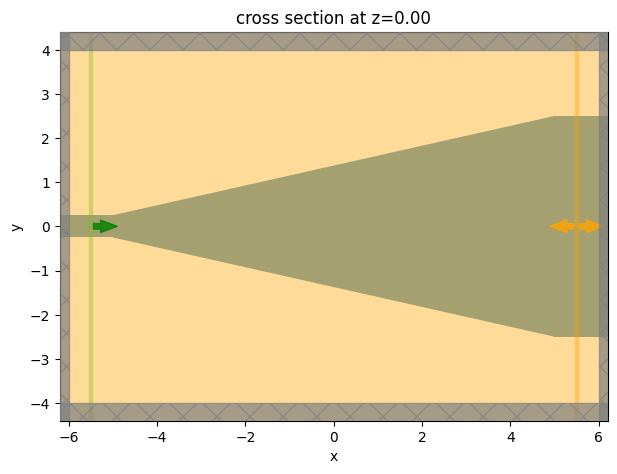

In [14]:
# desired ys
ys0 = np.linspace(wg_width_in/2 + 0.001, wg_width_out/2 - 0.001, num_points)

# corresponding parameters
params0 = get_params(ys0)

# make the simulation corresponding to these parameters
sim = make_sim_params(params0, include_field_mnt=True)
ax = sim.plot(z=0)

Lets get the penalty value corresponding to this design, it should be relatively low, but the random variations could introduce a bit of penalty.

In [15]:
penalty_value = penalty.evaluate(vertices0)
print(f'starting penalty = {float(penalty_value):.2e}')

starting penalty = 0.00e+00


Finally, let's run this simulation to get a feeling for the initial device performance.

In [16]:
sim_data = web.run(sim.to_simulation()[0], task_name='taper fields')

17:53:06 -03 Created task 'taper fields' with task_id                           
             'fdve-cf6300e1-3e08-4a63-a999-528a07f533bb' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=759204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=911666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\taskId]8;;\]8;id=759204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\=]8;;\]8;id=92002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\fdve]8;;\]8;id=759204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\-cf6300e1-3e0]8;;\
             ]8;id=759204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\8-4a63-a999-528a07f533bb']8;;\.

Output()

17:53:09 -03 status = queued

Output()

17:53:18 -03 status = preprocess

17:53:26 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

17:53:27 -03 running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:53:35 -03 early shutoff detected at 40%, exiting.

             status = postprocess

Output()

17:53:45 -03 status = success

             View simulation result at                                          
             ]8;id=370387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=796552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\taskId]8;;\]8;id=370387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\=]8;;\]8;id=635224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\fdve]8;;\]8;id=370387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\-cf6300e1-3e0]8;;\
             ]8;id=370387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cf6300e1-3e08-4a63-a999-528a07f533bb\8-4a63-a999-528a07f533bb']8;;\.

Output()

17:53:51 -03 loading simulation from simulation_data.hdf5

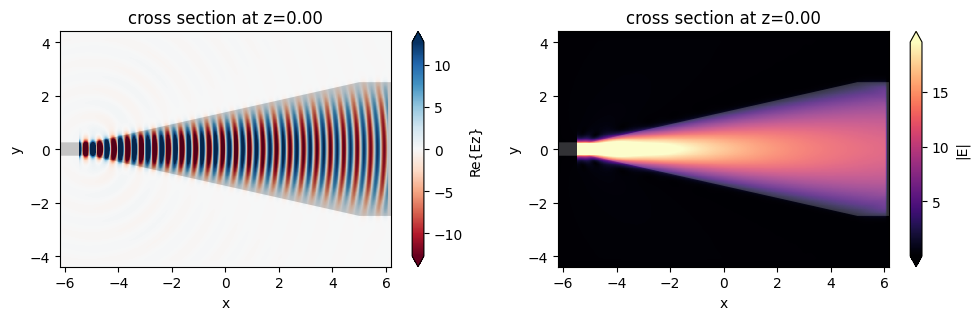

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
sim_data.plot_field(field_monitor_name='field', field_name='Ez', val='real', ax=ax1)
sim_data.plot_field(field_monitor_name='field', field_name='E', val='abs', ax=ax2)
plt.show()


## Gradient-based Optimization

Now that we have our design and post processing functions set up, we are finally ready to put everything together to start optimizing our device with inverse design.

We first set up an objective function that takes the parameters, sets up and runs the simulation, and returns the transmission minus the penalty of the parameters.


In [18]:
def objective(parameters: np.ndarray, verbose: bool = False) -> float:
    """Construct simulation, run, and measure transmission."""
    sim = make_sim_params(parameters, include_field_mnt=False)
    sim_data = run(sim, task_name='adjoint_taper', path='data/simulation.hdf5', verbose=verbose)
    return measure_transmission(sim_data) - penalty.evaluate(sim.input_structures[0].geometry.vertices)

To test our our objective, we will use jax to make and run a function that returns the objective value and its gradient.

In [19]:
grad_fn = jax.value_and_grad(objective)

In [20]:
val, grad = grad_fn(params0, verbose=True)

17:54:39 -03 WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

17:54:40 -03 Created task 'adjoint_taper' with task_id                          
             'fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=314117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=192523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\taskId]8;;\]8;id=314117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\=]8;;\]8;id=109192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\fdve]8;;\]8;id=314117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\-bb88979f-f39]8;;\
             ]8;id=314117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\4-4f6d-9b99-4e73b6d15623']8;;\.

Output()

Output()

17:54:44 -03 status = queued

Output()

17:54:54 -03 status = preprocess

17:55:00 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:55:08 -03 early shutoff detected at 40%, exiting.

17:55:09 -03 status = postprocess

Output()

17:55:17 -03 status = success

             View simulation result at                                          
             ]8;id=891948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=472716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\taskId]8;;\]8;id=891948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\=]8;;\]8;id=360361;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\fdve]8;;\]8;id=891948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\-bb88979f-f39]8;;\
             ]8;id=891948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb88979f-f394-4f6d-9b99-4e73b6d15623\4-4f6d-9b99-4e73b6d15623']8;;\.

Output()

17:55:19 -03 loading simulation from simulation_data.hdf5

             WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

17:55:21 -03 WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: 'JaxPolySlab'-containing                                  
             'JaxSimulation.input_structures[0]' intersects with                
             'JaxSimulation.structures[0]'. Note that in this version of the    
             adjoint plugin, there may be errors in the gradient when           
             'JaxPolySlab' intersects with background structures.               

             WARNING: Suppressed 1 WARNING message.                             

             Created task 'adjoint_taper_adj' with task_id                      
             'fdve-829c708b-56bb-44a9-85eb-d12ead875af4' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=323271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=479289;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\taskId]8;;\]8;id=323271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\=]8;;\]8;id=908604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\fdve]8;;\]8;id=323271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\-829c708b-56b]8;;\
             ]8;id=323271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\b-44a9-85eb-d12ead875af4']8;;\.

Output()

Output()

17:55:25 -03 status = queued

Output()

17:55:34 -03 status = preprocess

17:55:37 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

17:55:38 -03 running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:55:46 -03 early shutoff detected at 8%, exiting.

             status = postprocess

Output()

17:55:53 -03 status = success

             View simulation result at                                          
             ]8;id=679975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=249525;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\taskId]8;;\]8;id=679975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\=]8;;\]8;id=963902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\fdve]8;;\]8;id=679975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\-829c708b-56b]8;;\
             ]8;id=679975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-829c708b-56bb-44a9-85eb-d12ead875af4\b-44a9-85eb-d12ead875af4']8;;\.

Output()

In [21]:
print(f'objective = {val:.2e}')
print(f'gradient = {np.nan_to_num(grad)}')

objective = 7.19e-01
gradient = [ 2.71207769e-03  1.06148072e-01  4.84825969e-02 -1.41210541e-01
 -2.67507136e-01 -3.53514314e-01 -4.04454678e-01 -3.16792846e-01
 -2.08037823e-01 -8.59880447e-02  1.24843515e-01  1.69099435e-01
  4.28064093e-02  1.63800269e-02  9.93956625e-02  2.47591525e-01
  3.55272055e-01  3.94703865e-01  4.48716551e-01  3.94270569e-01
  2.96383291e-01  2.34637365e-01  1.15221784e-01  9.00208130e-02
  1.12314552e-01  4.43161428e-02  6.85510552e-03 -2.83381902e-02
 -5.76341972e-02 -4.27867882e-02 -3.37758288e-02  9.33956075e-03
  3.78074571e-02  3.67486328e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.39209589e-02  8.26518703e-03
 -7.68248085e-03 -3.43262851e-02 -4.34620529e-02 -4.13822420e-02
 -4.34709378e-02 -4.43057232e-02 -4.08759601e-02 -3.75956520e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.03490365e-02 -4.57080789e-02 -5.10892384e-02
 -4.67417762e-02 -5.29423878e-02 -4.61914130e-02 -4.059698

Now we can run `optax`'s Adam optimization loop with this `value_and_grad()` function. See tutorial 3 for more details on the implementation.

In [22]:
import optax

# turn off warnings to reduce verbosity
td.config.logging_level='ERROR'

# hyperparameters
num_steps = 41
learning_rate = 0.01

# initialize adam optimizer with starting parameters
params = np.array(params0).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]

for i in range(num_steps):

    # compute gradient and current objective funciton value
    value, gradient = grad_fn(params, verbose=False)
    
    # convert nan to 0 (infinite radius of curvature) and multiply all by -1 to maximize obj_fn.
    gradient = -1 * np.nan_to_num(np.array(gradient.copy()))

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    objective_history.append(value)
    param_history.append(params)    


step = 1
	J = 7.1900e-01
	grad_norm = 1.2431e+00
step = 2
	J = 7.4457e-01
	grad_norm = 3.0956e+00
step = 3
	J = 7.8507e-01
	grad_norm = 3.9803e+00
step = 4
	J = 8.2712e-01
	grad_norm = 2.8943e+00
step = 5
	J = 8.5855e-01
	grad_norm = 3.0015e+00
step = 6
	J = 8.8245e-01
	grad_norm = 3.9600e+00
step = 7
	J = 8.7541e-01
	grad_norm = 5.5646e+00
step = 8
	J = 8.9146e-01
	grad_norm = 5.3756e+00
step = 9
	J = 8.9377e-01
	grad_norm = 6.2556e+00
step = 10
	J = 9.1782e-01
	grad_norm = 4.8957e+00
step = 11
	J = 9.2116e-01
	grad_norm = 4.9372e+00
step = 12
	J = 9.2062e-01
	grad_norm = 6.2027e+00
step = 13
	J = 9.4761e-01
	grad_norm = 4.1500e+00
step = 14
	J = 9.4234e-01
	grad_norm = 4.1013e+00
step = 15
	J = 9.3209e-01
	grad_norm = 4.6997e+00
step = 16
	J = 9.3425e-01
	grad_norm = 4.5537e+00
step = 17
	J = 9.4294e-01
	grad_norm = 4.1936e+00
step = 18
	J = 9.4867e-01
	grad_norm = 4.1816e+00
step = 19
	J = 9.5344e-01
	grad_norm = 4.0164e+00
step = 20
	J = 9.5720e-01
	grad_norm = 3.5860e+00
step = 21

In [23]:
params_best = param_history[-1]

We see that our objective has increased steadily from a transmission of 56% to about 95%!

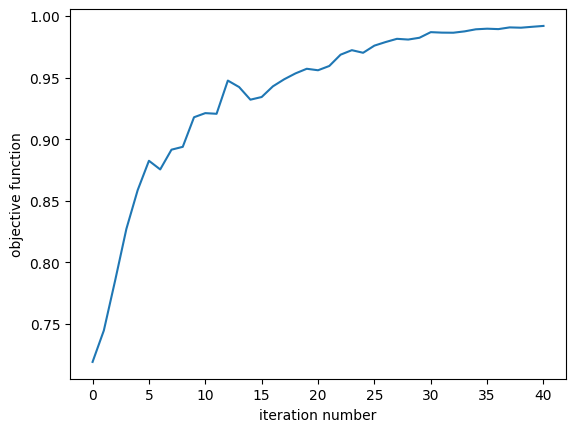

In [24]:
ax = plt.plot(objective_history)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.show()

Our final device displays smooth features and no sharp corners. Without our penalty this would have not been the case!

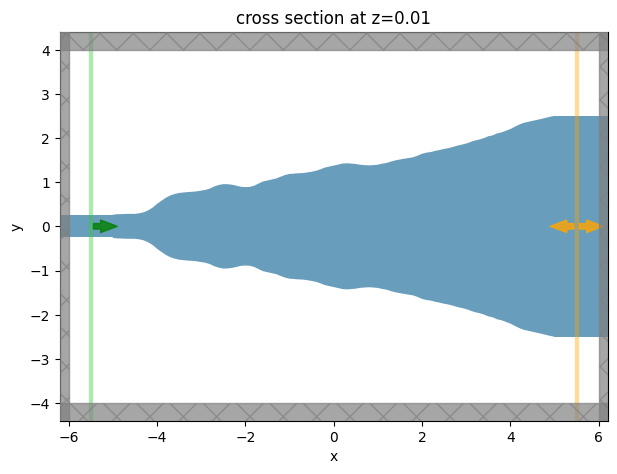

In [25]:
sim_best = make_sim_params(param_history[-1], include_field_mnt=True)
ax = sim_best.plot(z=0.01)

In [26]:
sim_data_best = td.web.run(sim_best.to_simulation()[0], task_name='taper final')


18:49:46 -03 Created task 'taper final' with task_id                            
             'fdve-189329bc-803d-45a7-9385-fe224c400888' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=966487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=109609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\taskId]8;;\]8;id=966487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\=]8;;\]8;id=340334;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\fdve]8;;\]8;id=966487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\-189329bc-803]8;;\
             ]8;id=966487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\d-45a7-9385-fe224c400888']8;;\.

Output()

18:49:49 -03 status = queued

Output()

18:50:02 -03 status = preprocess

18:50:06 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:50:13 -03 early shutoff detected at 44%, exiting.

             status = postprocess

Output()

18:50:23 -03 status = success

             View simulation result at                                          
             ]8;id=695283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=382776;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\taskId]8;;\]8;id=695283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\=]8;;\]8;id=708613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\fdve]8;;\]8;id=695283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\-189329bc-803]8;;\
             ]8;id=695283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-189329bc-803d-45a7-9385-fe224c400888\d-45a7-9385-fe224c400888']8;;\.

Output()

18:50:28 -03 loading simulation from simulation_data.hdf5

Comparing the field patterns, we see that the optimized device gives a much more uniform field profile at the output waveguide, as desired. One can further check that this device and field pattern matches the referenced paper quite nicely!

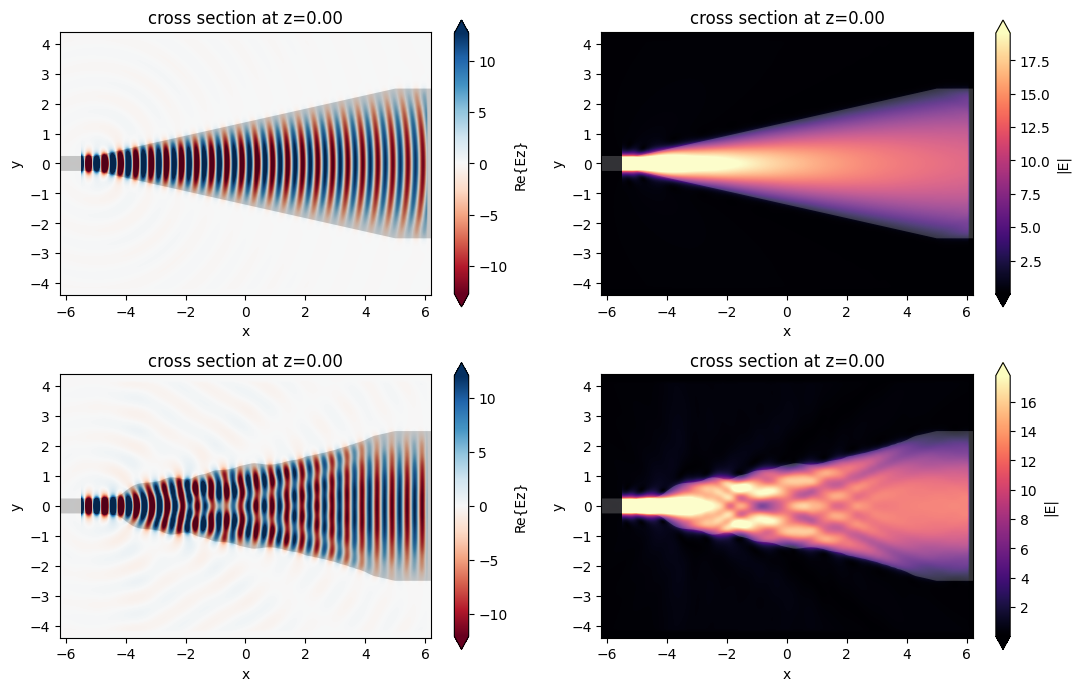

In [27]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(11, 7))

# plot original
sim_data.plot_field(field_monitor_name='field', field_name='Ez', val='real', ax=ax1)
sim_data.plot_field(field_monitor_name='field', field_name='E', val='abs', ax=ax2)

# plot optimized
sim_data_best.plot_field(field_monitor_name='field', field_name='Ez', val='real', ax=ax3)
sim_data_best.plot_field(field_monitor_name='field', field_name='E', val='abs', ax=ax4)

plt.show()


In [28]:
transmission_start = float(measure_transmission(sim_data))
transmission_end = float(measure_transmission(sim_data_best))
print(f'Transmission improved from {(transmission_start * 100):.2f}% to {(transmission_end * 100):.2f}%')

Transmission improved from 71.90% to 99.48%
